In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import datetime,timedelta,date
import matplotlib.pyplot as plt
from matplotlib import cm
cmap = cm.get_cmap('rainbow_r')
from math import *
%matplotlib nbagg

# Calculos proyecto todo el año

In [2]:
longitud=-2.506
longzonahoraria=0
latitud=50.643

ipanel=30
orientacion=0

Gsc=1359.8 # 1360.8+-0.5 W /m2 Constante solar segun NASA (EXPERIMENTAL)
Kt=1 #Cielo despejado indice de claridad (o de nubosidad) 1=despejado

Azimuthval=[]
hval=[]
itval=[]
#DIAS
for DIACALC in xrange(365):
    dias=range(1,366)
    horasdia=[0.0+i*5.0/60 for i in xrange(24*60/5)]

    #declinacion
    Tparam=[pi*2*(i-1)/365 for i in dias]
    declinacion=[(0.006918-0.39912*cos(i)+0.070257*sin(i)-0.006758*cos(2*i)+0.000907*sin(2*i)-0.002697*cos(3*i)+0.00148*sin(3*i))*(180/pi) for i in Tparam]

    #TIEMPO
    #Ecuacion del tiempo
    B=[(360.0/364)*(i-81) for i in dias]
    ETmin=[9.87*sin(2*i*pi/180) -7.53*cos(i*pi/180) - 1.5*sin(i*pi/180) for i in B]

    #Time correction= 4*(Long-15*DTgmt)+ETmin
    TCh=[(4*(longitud-longzonahoraria)+i)/60 for i in ETmin]

    #Local Solar time
    LST=[horasdia[i]+TCh[DIACALC] for i in xrange(len(horasdia))]

    #Angulo horario w
    w=[(i-12)*15 for i in LST]

    #Altura del Sol (h)
    h=[asin(sin(declinacion[DIACALC]*pi/180)*sin(latitud*pi/180)+cos(declinacion[DIACALC]*pi/180)*cos(latitud*pi/180)*cos(i*pi/180))/pi*180 for i in w]

    #Azimuth (Az para calcs, Azimuth va entre -180 y 180 para plot)
    Az=[acos((sin(h[i]*pi/180)*sin(latitud*pi/180)-sin(declinacion[DIACALC]*pi/180))/(cos(h[i]*pi/180)*cos(latitud*pi/180)))/pi*180 for i in xrange(len(h))]

    Azimuth=[]
    for i in xrange(len(w)):
        if w[i]<0:
            Azimuth.append(-Az[i])
        else:
            Azimuth.append(Az[i])
            
    Azimuthval=Azimuthval+Azimuth
    hval=hval+h
    
    #Inclinacion (Con inclinacion<=90 le da el sol al panel)
    inclinacion=[180.0/pi*acos(\
                               sin(declinacion[DIACALC]*pi/180)*sin(latitud*pi/180.0)*cos(ipanel*pi/180)\
                               -sin(declinacion[DIACALC]*pi/180)*cos(latitud*pi/180.0)*sin(ipanel*pi/180)*cos(orientacion*pi/180)\
                               +cos(declinacion[DIACALC]*pi/180)*cos(latitud*pi/180.0)*cos(ipanel*pi/180)*cos(w[i]*pi/180)\
                              +cos(declinacion[DIACALC]*pi/180)*sin(latitud*pi/180.0)*sin(ipanel*pi/180)*cos(orientacion*pi/180)*cos(w[i]*pi/180)\
                              +cos(declinacion[DIACALC]*pi/180)*sin(ipanel*pi/180)*sin(orientacion*pi/180)*sin(w[i]*pi/180)) for i in xrange(len(h))]

    #Rb (radiancion sobre superficie inclinada/radiacion sobre horizontal (pag46))

    Rb=[cos(inclinacion[i]*pi/180)/sin(h[i]*pi/180) for i in xrange(len(inclinacion))]
    for i in xrange(len(Rb)):
        if Rb[i]<0:
            Rb[i]=0

    #Radiación exterior a la atmosfera sobre plano horizontal Go (W/m2)
    Go=[Gsc*(1+0.033*cos(360*DIACALC/365*pi/180))*sin(h[i]*pi/180) for i in xrange(len(h))]
    for i in xrange(len(Go)):
        if Go[i]<0:
            Go[i]=0
    
    HdH=0.2

    #irradiancia directa total It
    it=[Go[i]*Rb[i]+HdH*Go[i] for i in xrange(len(Rb))]
    for j in xrange(len(it)):
        if it[j]<0:
            it[j]=0
    itval=itval+it

<IPython.core.display.Javascript object>


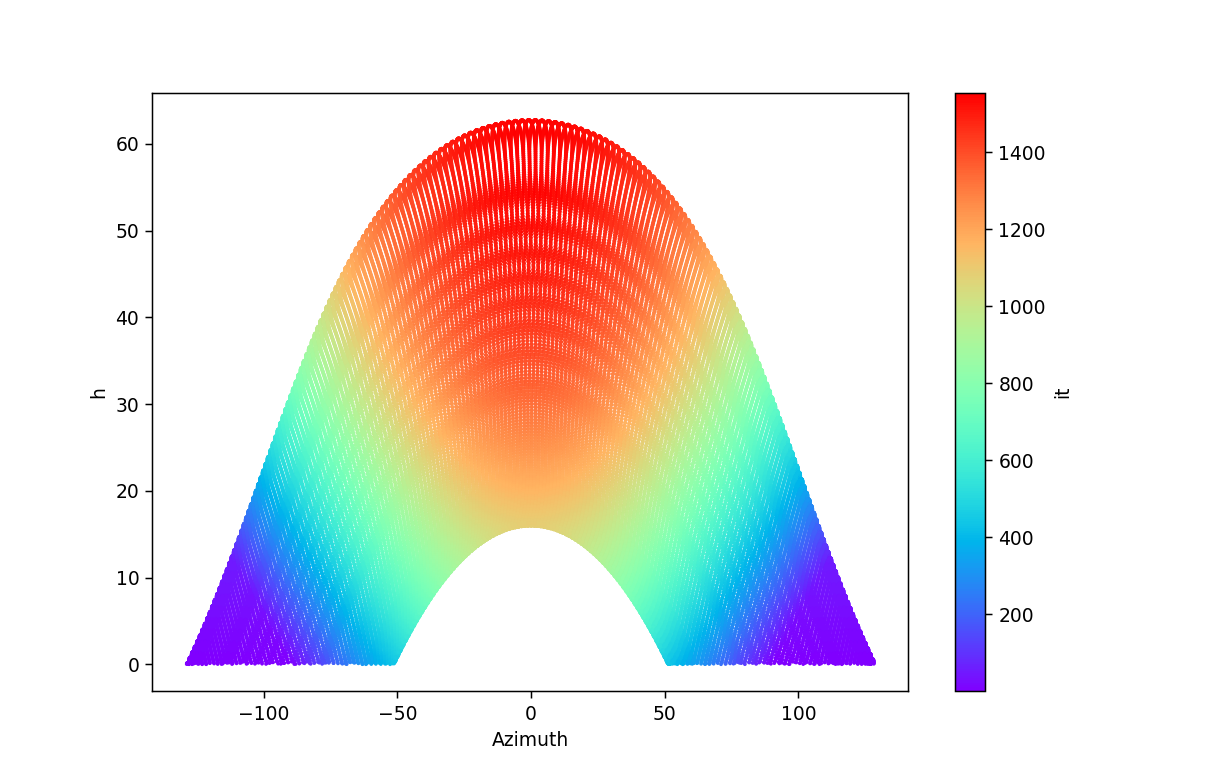

In [3]:
df=pd.DataFrame()
df['Azimuth']=Azimuthval
df['h']=hval
df['it']=itval
df[df['h']>0].plot.scatter(x='Azimuth',y='h',c='it',cmap='rainbow',style='o',s=1)

# Carga datos

In [11]:
longitud=-2.506
longzonahoraria=0
latitud=50.643

ipanel=30
orientacion=0
reflectividad=0.2

Gsc=1359.8 # 1360.8+-0.5 W /m2 Constante solar segun NASA (EXPERIMENTAL)
Kt=1 #Cielo despejado indice de claridad (o de nubosidad) 1=despejado

#Hd/H ->pag49, el valor depende de Kt OJO ES PARA TOTALES DIARIOS
#0.99 si Kt<=0.17
#1.188-2.272*Kt+9.473*Kt**2-21.865*Kt**3+14.648*Kt**4      0.17<Kt<=0.75
#-0.54*Kt+0.632   0.75<Kt<=0.8
#0.2   Kt>0.8
HdH=0.2



a=pd.read_csv('PotenciaNott.csv',sep=';',decimal='.')

#a=a[:5][a.columns[:5]]

a['timestamp'] = a['timestamp'].apply(lambda n: datetime.strptime(n, '%Y-%m-%d %H:%M:%S'))
a=a.sort_values(by='timestamp')
a.reset_index(inplace=True)
a['dayofyear'] = a['timestamp'].apply(lambda n: (n.toordinal() - date(n.year, 1, 1).toordinal() + 1))
a['hour'] = a['timestamp'].apply(lambda n: (n.hour + n.minute/60.0))


#DECLINACION
a['Tparam'] = pi*2*(a['dayofyear']-1)/365
def fdeclinacion(x):
    Tparam=x
    return (0.006918-0.39912*cos(Tparam)\
                             +0.070257*sin(Tparam)-0.006758*cos(2*Tparam)\
                             +0.000907*sin(2*Tparam)-0.002697*cos(3*Tparam)\
                             +0.00148*sin(3*Tparam))*(180/pi)
a['declinacion']=a['Tparam'].apply(fdeclinacion)

a=a.drop('Tparam',axis=1)


#TIEMPO
#Ecuacion del tiempo
def ftoTSV(x):
    dia=x[0]
    hora=x[1]
    
    B=(360.0/364)*(dia-81)
    ETmin=9.87*sin(2*B*pi/180) -7.53*cos(B*pi/180) - 1.5*sin(B*pi/180)

    #Time correction= 4*(Long-15*DTgmt)+ETmin
    TCh=(4*(longitud-longzonahoraria)+ETmin)/60
    
    #Local Solar time
    if ((dia>=87) & (dia<304)): #Horario de verano
        LST=hora+TCh-1
    else:
        LST=hora+TCh
        
    return LST
a['hour']=a[['dayofyear','hour']].apply(ftoTSV,axis=1)

#Angulo horario w
a['w']=(a['hour']-12)*15


#Altura del Sol (h)
def fh(x):
    declinacion=x[0]
    w=x[1]
    
    h=asin(sin(declinacion*pi/180)*sin(latitud*pi/180)+cos(declinacion*pi/180)*cos(latitud*pi/180)*cos(w*pi/180))/pi*180
    return h
a['h']=a[['declinacion','w']].apply(fh,axis=1)

#Azimuth (Az para calcs, Azimuth va entre -180 y 180 para plot)
def fAzimuth(x):
    declinacion=x[0]
    w=x[1]
    h=x[2]
    Az=acos((sin(h*pi/180)*sin(latitud*pi/180)-sin(declinacion*pi/180))\
             /(cos(h*pi/180)*cos(latitud*pi/180)))/pi*180

    if (w<0):
        Az=-Az
    return Az

a['Azimuth']=a[['declinacion','w','h']].apply(fAzimuth,axis=1)

#Inclinacion (Con inclinacion<=90 le da el sol al panel)
def finclinacion(x):
    declinacion=x[0]
    w=x[1]
    inclinacion=180.0/pi*acos(\
                              sin(declinacion*pi/180)*sin(latitud*pi/180.0)*cos(ipanel*pi/180)\
                              -sin(declinacion*pi/180)*cos(latitud*pi/180.0)*sin(ipanel*pi/180)*cos(orientacion*pi/180)\
                              +cos(declinacion*pi/180)*cos(latitud*pi/180.0)*cos(ipanel*pi/180)*cos(w*pi/180)\
                              +cos(declinacion*pi/180)*sin(latitud*pi/180.0)*sin(ipanel*pi/180)*cos(orientacion*pi/180)*cos(w*pi/180)\
                              +cos(declinacion*pi/180)*sin(ipanel*pi/180)*sin(orientacion*pi/180)*sin(w*pi/180))
    return inclinacion

a['inclinacion']=a[['declinacion','w']].apply(finclinacion,axis=1)

#Rb (radiancion sobre superficie inclinada/radiacion sobre horizontal (pag46))

def fRb(x):
    h=x[0]
    inclinacion=x[1]
    Rb=cos(inclinacion*pi/180)/sin(h*pi/180)
    if Rb<0:#Reemplaza los Rb negativos por cero
        Rb=0
    return Rb
a['Rb']=a[['h','inclinacion']].apply(fRb,axis=1)

#Radiación exterior a la atmosfera sobre plano horizontal Go (W/m2)
def fGo(x):
    h=x[0]
    dia=x[1]
    Go=Gsc*(1+0.033*cos(360*dia/365*pi/180))*sin(h*pi/180)
    if Go<0:  #Reemplaza las irradiancias negativas por cero
        Go=0
    return Go
a['Go']=a[['h','dayofyear']].apply(fGo,axis=1)


#irradiancia directa total It
#a['it']=a['Go']*a['Rb']+HdH*a['Go']
a['it']=a['Go']*a['Rb'] + HdH*a['Go']*((1+cos(ipanel/180))/2)\
                         +(a['Go']*a['Rb']+HdH*a['Go'])*((1-cos(ipanel*pi/180))/2)*reflectividad 

a['itpanels']=a['it']*0.245*16*24  #paneles de 245W a 1000 W/m2 ->0.245 m2 /// Hay 16strings de 24 paneles por caja
a['n']=a['0_PBOX_01']/a['itpanels'] 





a

,index,timestamp,0_PBOX_01,0_PBOX_02,0_PBOX_03,0_PBOX_04,0_PBOX_05,0_PBOX_06,0_PBOX_07,0_PBOX_08,...,declinacion,w,h,Azimuth,inclinacion,Rb,Go,it,itpanels,n
0,13369,2016-05-01 05:05:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-120.492414,-6.262981,-123.186126,111.501365,3.359762,0.000000,0.000000,0.000000,NaN
1,13370,2016-05-01 05:10:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-119.242414,-5.595785,-122.175146,110.452555,3.583558,0.000000,0.000000,0.000000,NaN
2,13371,2016-05-01 05:15:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-117.992414,-4.921164,-121.170311,109.398098,3.871656,0.000000,0.000000,0.000000,NaN
3,13372,2016-05-01 05:20:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-116.742414,-4.239369,-120.171390,108.338249,4.256108,0.000000,0.000000,0.000000,NaN
4,13373,2016-05-01 05:25:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-115.492414,-3.550648,-119.178143,107.273249,4.794527,0.000000,0.000000,0.000000,NaN
5,13374,2016-05-01 05:30:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-114.242414,-2.855246,-118.190323,106.203329,5.601910,0.000000,0.000000,0.000000,NaN
6,13375,2016-05-01 05:35:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-112.992414,-2.153404,-117.207681,105.128704,6.945765,0.000000,0.000000,0.000000,NaN
7,13376,2016-05-01 05:40:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-111.742414,-1.445363,-116.229956,104.049583,9.624355,0.000000,0.000000,0.000000,NaN
8,13377,2016-05-01 05:45:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-110.492414,-0.731357,-115.256888,102.966158,17.578450,0.000000,0.000000,0.000000,NaN
9,13378,2016-05-01 05:50:00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,15.110784,-109.242414,-0.011620,-114.288207,101.878618,1014.971146,0.000000,0.000000,0.000000,NaN


<IPython.core.display.Javascript object>


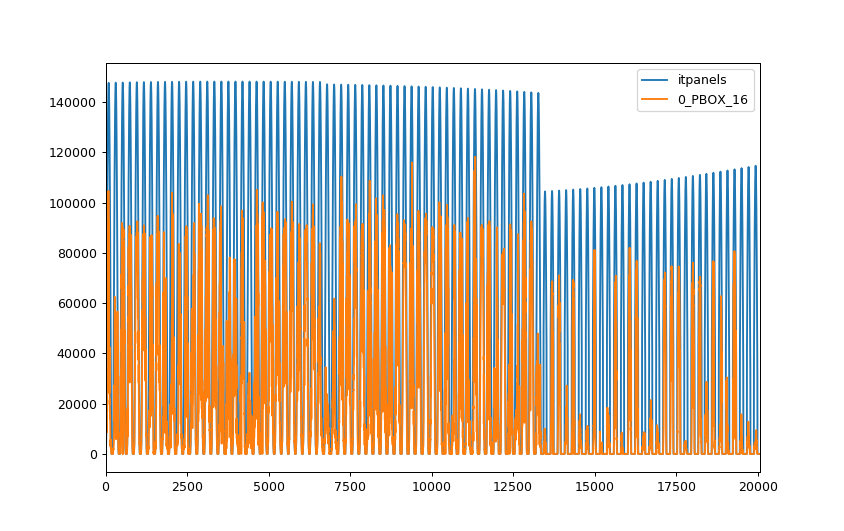

In [12]:
a[['itpanels','0_PBOX_16']].plot()

<IPython.core.display.Javascript object>


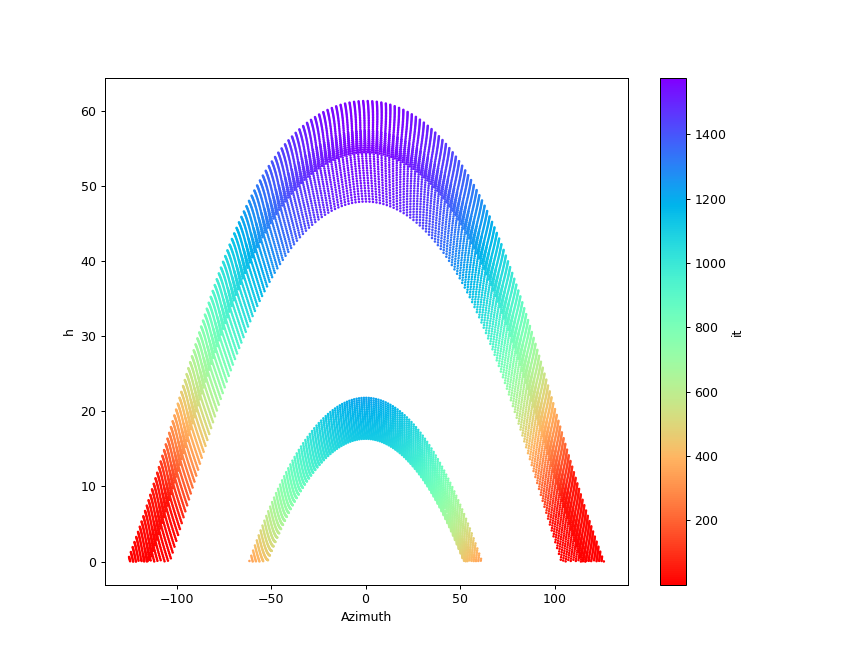

In [13]:
a[a['h']>0].plot.scatter(x='Azimuth',y='h',c='it',cmap=cmap,style='o',s=1)

<IPython.core.display.Javascript object>


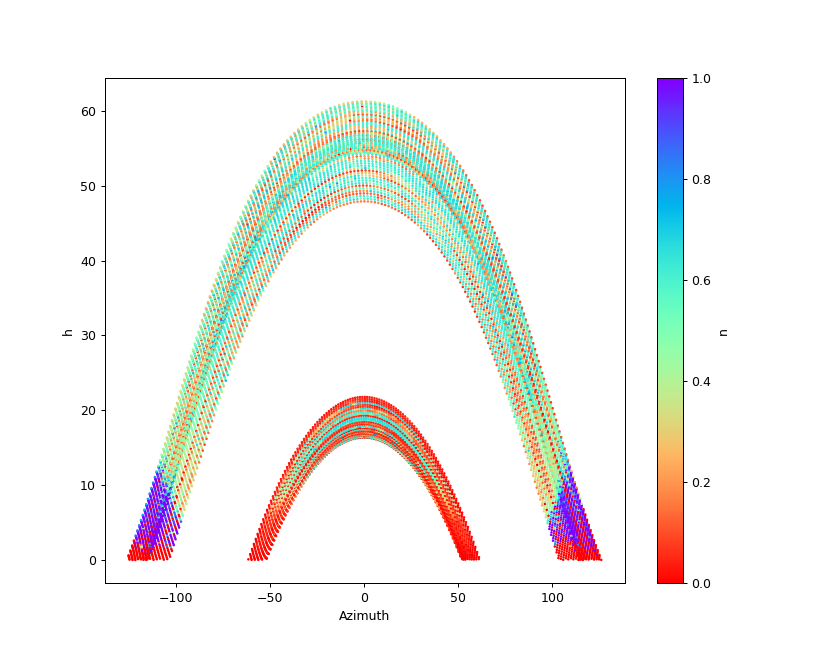

In [14]:
a.plot.scatter(x='Azimuth',y='h',c='n',cmap=cmap,vmin=0, vmax=1,style='o',s=1)

In [ ]:
#DIAS DEL CAMBIO DE HORA UK
#        Forward     Back
#2016	27 March	30 October
#Dia       87           304
date(2016,10, 30).toordinal()-date(2016, 1, 1).toordinal() + 1

In [131]:
sin(2*pi*(30)/365)

0.49377555015997715